In [1]:
import os
import torch
import yaml
import glob
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import pandas as pd


In [2]:
def extract_files():
    import google.colab
    import zipfile

    google.colab.drive.mount('/content/drive')
    PROJECT_DIR = "/content/drive/MyDrive/thesis/data/"

    zip_ref = zipfile.ZipFile(PROJECT_DIR + "fiveK.zip", 'r')
    zip_ref.extractall(".")
    zip_ref.close()

In [3]:
if 'google.colab' in str(get_ipython()):
  extract_files()
  config_path = "/content/drive/MyDrive/thesis/config.yaml"
else:
  config_path = "../../config.yaml"

Mounted at /content/drive


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [5]:
try:
    # Load configuration
    with open(config_path, 'r') as config_file:
        config = yaml.safe_load(config_file)
except:
    raise FileNotFoundError(f"Config file not found at path: {config_path}")

In [6]:
base_checkpoint_path = os.path.join(config['paths']['checkpoints'], 'resetnet50_scratch')

In [7]:
def load_best_checkpoint(checkpoint_dir):
    # Check if the directory exists
    if not os.path.exists(base_checkpoint_path):
        print(f"No directory found: {checkpoint_dir}")
        return None
      # Get a list of all checkpoint files in the directory
    checkpoint_files = glob.glob(os.path.join(checkpoint_dir, 'resetnet50_scratch_*.pth'))

    # Check if any checkpoint files are present
    if not checkpoint_files:
        print(f"No checkpoints found in the directory: {checkpoint_dir}")
        return None

    best_accuracy = 0.0
    accuracies = []
    epochs = []
    lossess = []
    for checkpoint_file in checkpoint_files:
        checkpoint = torch.load(checkpoint_file, map_location=torch.device(device))
        accuracies.append(checkpoint['accuracy'].cpu())
        epochs.append(checkpoint['epoch'])
        lossess.append(checkpoint['loss'])
        if best_accuracy < checkpoint['accuracy']:
            best_accuracy = checkpoint['accuracy']
            best_checkpoint = checkpoint

    return best_checkpoint, accuracies, epochs, lossess

In [8]:
checkpoint, accuracies, epochs, losses = load_best_checkpoint(base_checkpoint_path)

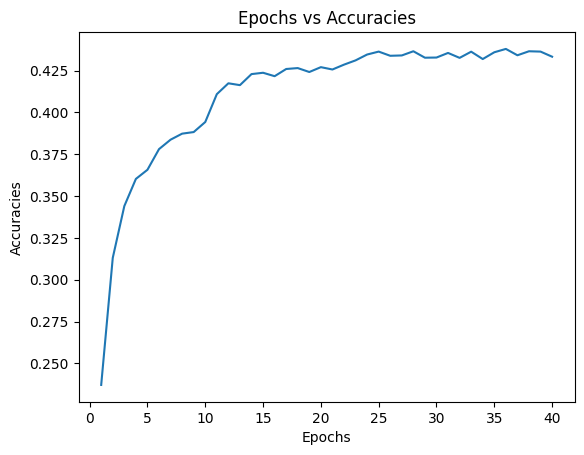

In [9]:
# Draw the plot between epochs and accuracies
import matplotlib.pyplot as plt
plt.plot(epochs, accuracies)
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.title('Epochs vs Accuracies')
plt.show()

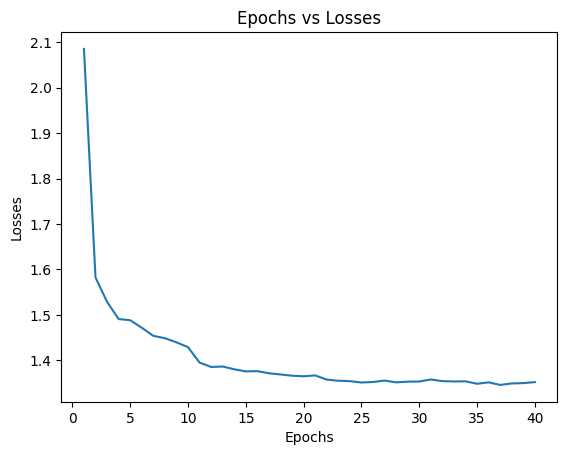

In [10]:
# Draw the plot between epochs and accuracies
import matplotlib.pyplot as plt
plt.plot(epochs, losses)
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Epochs vs Losses')
plt.show()

In [11]:
print(checkpoint['accuracy'])

tensor(0.4380, device='cuda:0', dtype=torch.float64)


In [12]:
model = torchvision.models.resnet50(weights=None)

num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 5)

model = model.to(device)

In [13]:
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [14]:
print(checkpoint['epoch'])

36


In [15]:
# List of class directories
class_directories = ['expA', 'expB', 'expC', 'expD', 'expE']

In [16]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, filename, transform=None):
        super().__init__()
        self.filename = filename
        self.transform = transform
        self.classname = self._extract_class_name(data_dir)
        self.encode = {k: i for i, k in enumerate(class_directories)}

        # Read the train.txt file and store the image paths
        with open(self.filename) as f:
            self.image_paths = [os.path.join(data_dir, line.strip()) for line in f]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path)
        label = self.encode[self.classname]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def _extract_class_name(self, root_dir):
        # Extract the class name from the root directory
        class_name = os.path.basename(root_dir)
        return class_name

In [17]:
data_folder = config['paths']['data']
test_file = config['paths']['test']

In [18]:
def read_dataset(data_folder, txt_file, trasform=None):
    # Create separate datasets for each class
    datasets = []

    for class_dir in class_directories:
        class_train_dataset = CustomDataset(
            data_dir=os.path.join(data_folder, class_dir),
            filename=os.path.join(txt_file),
            transform=trasform
        )
        datasets.append(class_train_dataset)
    return datasets

In [19]:

test_tr = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [20]:
test_dataset = torch.utils.data.ConcatDataset(read_dataset(data_folder, test_file, test_tr))

In [21]:
bs = 64

In [22]:
test_dataloader = DataLoader(test_dataset, batch_size=bs*2, shuffle=False)

In [23]:
def test_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0

    nb_classes = len(class_directories)
    confusion_matrix = np.zeros((nb_classes, nb_classes))

    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            for t, p in zip(labels, predicted):
                confusion_matrix[t.long(), p.long()] += 1

    return round(100 * correct / total, 2), confusion_matrix


In [24]:
accuracy, confusion_matrix = test_accuracy(model, test_dataloader, device)

In [25]:
print(f"Accuracy: {accuracy}%")

Accuracy: 48.0%


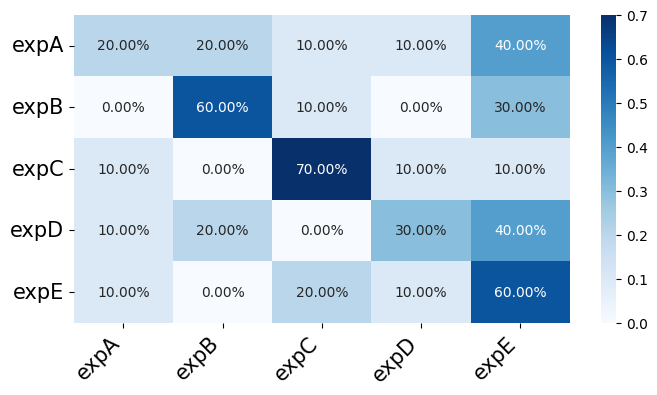

In [26]:

plt.figure(figsize=(8,4))

class_names = list(class_directories)
confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(float)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2%',  cmap='Blues')

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.show()

In [27]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [28]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = test_tr(img)
    img = img.unsqueeze(0)

    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_directories[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

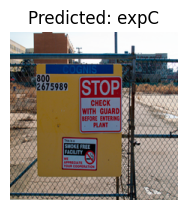

In [32]:
visualize_model_predictions(model, img_path=os.path.join(config['paths']['data'], 'expC', '4100.png'))